# The Rainbow Method Part I. Find an Ordinal Encoding
> 'When nature gives you a rainbow, take it.'

- author: Anna Arakelyan, Dmytro Karabash
- categories: [python, data science, classification, encoding]
- image: ../images/jd-rincs-9GkYmKYVoGY-unsplash.jpg
- permalink: /rainbow/
- hide: true

![rainbow](../images/jd-rincs-9GkYmKYVoGY-unsplash.jpg)

## Introduction

"I have 2000 features and I need to get to 50 features and keep the model as good or better" was how this all started. This is familiar to anyone in institutional data science where you need to carefully vet every model and look at each feature to make sure it is fine from the standpoint of regulation. What is valuable about this story is that it is based on a real production model that was developed by Anna Arakelyan at MassMutual and the Rainbow method suggested by Dmytro Karabash. We will get detailed results at the end but here's a preview for anyone who wants to take a peek:

Figure 1

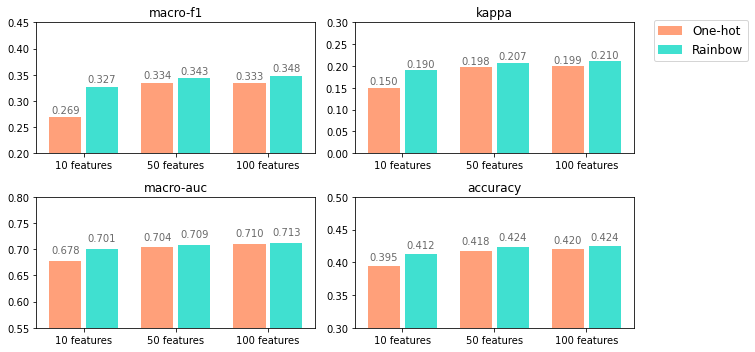

In [1]:
#hide_input

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
# Add 'rainbow_research.csv' and 'rainbow_research_feature_selection.csv' in the _notebooks folder
# Don't push data to repo - they must be ignored in .gitignore
results = pd.read_csv('rainbow_research.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})
feature_selection = pd.read_csv('rainbow_research_feature_selection.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})

results['method']=results['method'].replace({'one_hot': "One-hot", 'rainbow': "Rainbow"})

metrics=['accuracy', 'kappa', 'macro avg_f1-score', 'weighted avg_f1-score', 'macro avg_roc_auc', 'weighted avg_roc_auc']
tmp = feature_selection.groupby(['Num_features', 'method'])[metrics].mean().round(4).reset_index()

tmp['Num_features']=tmp['Num_features'].str.replace('top_',"").astype(int)
table1 = tmp.set_index(['Num_features', 'method']).sort_index()

table1=table1.rename(columns={'macro avg_f1-score': 'macro-f1',
                       'weighted avg_f1-score':'weighted-f1',
                       'macro avg_roc_auc':'macro-auc',
                       'weighted avg_roc_auc' : 'weighted-auc'
                      })
# table1[['macro-f1','accuracy','kappa','macro-auc']].round(2)
table11 = table1[['macro-f1','accuracy','kappa','macro-auc']].round(4).reset_index()


def autolabel(rects, i, j, decimals=3):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axs[i, j].text(rect.get_x() + rect.get_width()/2., 1.015*height,
                '%.{}f'.format(decimals) % height,
                ha='center', va='bottom', color = 'dimgrey')  

def make_subplot(table11, metric, x, i, j, colors, ylimits=[]):
    y1 = table11[table11['method']=='one_hot'][metric]
    y2 = table11[table11['method']=='rainbow'][metric]
    rects1 = axs[i, j].bar(x-0.2, y1, width, label = 'One-hot', color = colors[0])
    rects2 = axs[i, j].bar(x+0.2, y2, width, label = 'Rainbow', color = colors[1]) 
    axs[i, j].set_ylim(ylimits)
    axs[i, j].set_xticks(x)    
    axs[i, j].set_xticklabels(['10 features', '50 features', '100 features'], rotation=0)
    axs[i, j].set_title(metric)
    autolabel(rects1, i, j)
    autolabel(rects2, i, j)
    
x = np.arange(3)
fig, axs = plt.subplots(2, 2, figsize=(9,5))
width = 0.35
colors = ['lightsalmon', 'turquoise']
make_subplot(table11, 'macro-f1', x, 0, 0, colors, [0.2,0.45])
make_subplot(table11, 'kappa', x, 0, 1, colors, [0, 0.30])
make_subplot(table11, 'macro-auc', x, 1, 0, colors, [0.55, 0.80])
make_subplot(table11, 'accuracy', x, 1, 1, colors, [0.3, 0.50])
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2.4), loc='upper left', prop={'size': 12})
plt.show()

The rainbow method outperforms the One-hot easily. The rainbow method even shows better results for 50 features than One-hot does for 100. Also note that when dropping from 50 to 10 features, the reduction in macro-f1 if you use One-hot is 6 times that of the rainbow method (3 times for kappa and accuracy, 2 times for macro-auc).

>Both models keep improving as the number of features goes up. Though the improvement is substantially faster and larger for the rainbow method.

**In this series of articles, we will introduce the Rainbow encoding method and will discuss its advantages over the conventional One-hot.** <br>
Part I below explains how the method works, shows that it preserves full data signal, and provides examples of its use for various kinds of categorical variables. Part II explores its empirical application to a real business data science problem - Mindset Segmentation model at MassMutual using the Acxiom database. Part III provides the mathematical foundation for the method and shows that it reduces model complexity and helps avoid overfitting.

## Background

Data encoding is a crucial part of any data science pipeline. No matter which machine learning algorithm is used - there is no avoiding of data cleaning and encoding. Especially with dirty and complex real data sets, ensuring the most appropriate and efficient way of feature encoding and engineering is a nontrivial problem. While encoding quantitative and binary columns is usually a straightforward task, the encoding of categorical variables deserves a deeper look. 
<br><br>
One of the most popular encoding methods for categorical variables has been the One-hot procedure. It generates an indicator variable for every category and, thus, creates a set of K new features, where K is the number of categories.
One significant implication of this method is the dimensionality increase. Depending on the magnitude of K, it can have various undesirable technical consequences: substantial raise of computational complexity, loss of degrees of freedom (N-K, where N is the number of samples), multicollinearity, and, ultimately, an overfitted model. Non-technical consequences include unnecessary complications of the model that should be communicated to final users and that contradict the law of parsimony aka Occam's razor.

## Method

We call it rainbow from a very simple analogy: if you have a categorical column with value names "Red", "Orange", "Yellow", "Green", "Blue", "Indigo" and "Violet", in other words - colors of the rainbow, instead of One-hot encoding, you can simply create one feature with encoding:
***
0 = "Red" <br>
1 = "Orange" <br>
2 = "Yellow" <br>
3 = "Green" <br>
4 = "Blue" <br>
5 = "Indigo" <br>
6 = "Violet"

This nicely replaces seven One-hot features with one rainbow.  

Most of the nominal variables, at the first glance, seem like they cannot be converted to a quantitative scale. This is where we suggest **finding a rainbow**.
<br>
The seemingly unordered categories acquire a perfect order if we find a scale, where each category fits into its unique place. With the color - the natural scale is Hue. But it is not the only one. We can think of, say, brightness, saturation, color temperature, etc. We invite you to experiment with a few different rainbows that might capture different nuances of the categorical quality. 

You can actually make and use two or more rainbows out of one categorical variable depending on the number of categories K and the context.

> We don't recommend using more than $\log_2 {K}$ rainbows because we do not want to surpass the number of encodings in a binary One-hot.


Why is rainbow better than any other choice? It is very simple and intuitively sensible. In many cases it is not even that important which rainbow you choose (and by that we mean the color order), it would still be better than using One-hot. The more natural orders are just likely to be slightly better than others and easier to interpret. 

> Hence our motto: "When nature gives you a rainbow, take it..."


**Important note**: this method is highly efficient in conjunction with the models that rely on variables as ranks rather than exact values. For example, decision trees, random forest, gradient boosting - these algorithms will output the same result if, say, the variable *Number of Children* is coded as 
***
0 = "0 Children" <br>
1 = "1 Child"<br>
2 = "2 Children"<br>
3 = "3 Children"<br>
4 = "4 or more Children" 
***
or as 
***
1 = "0 Children" <br>
2 = "1 Child"<br>
3 = "2 Children"<br>
4 = "3 Children"<br>
5 = "4 or more Children" 
***

or even as 
***
-100 = "0 Children" <br>
-85 = "1 Child"<br>
0 = "2 Children"<br>
10 = "3 Children"<br>
44 = "4 or more Children" 
***

as long as the correct order of the categories is preserved. The values themselves don't carry the quantitative function in these algorithms. It is the rank of the variable that matters, and a tree-based algorithm will use its 
magic to make the most appropriate splits to introduce new tree nodes.

The application of our method for other algorithms such as Linear Regression, Logistic Regression is out of the scope of this article. We expect that such a way of feature engineering would be still beneficial, but that is a subject of a different investigation.

Note that by using a rainbow rather than One-hot we are not losing any of the data signal. Let's explore that question below.

## Rainbow keeps the full signal

Let's zoom in for a minute on a classical rainbow example with just 4 values:

***
*Color* <br><br>
0 = "Red" <br>
1 = "Yellow" <br>
2 = "Green" <br>
3 = "Blue"
***

In the case of One-hot, we would create 4 features: <br>

*Color_Red* = 1 if *Color* = 0 and 0 otherwise,<br>
*Color_Yellow* = 1 if *Color* = 1 and 0 otherwise,<br>
*Color_Green* = 1 if *Color* = 2 and 0 otherwise,<br>
*Color_Blue* = 1 if *Color* = 3 and 0 otherwise.

In the case of Rainbow, we would just use the *Color* itself.

Let's compare the possible models made using these two methods: 4 features vs 1 feature. Let's for simplicity build a single decision tree. Let's look at a few scenarios of the data generating process.

### Scenario 1
Assume all the categories are wildly different, and each one introduces a substantial gain to the model. That means each One-hot feature is indeed critical - the model should separate between all 4 groups created by One-hot.

In that case, an algorithm such as *xgboost* will just make the splits between all the values which is perfectly equivalent to One-hot. So the same exact result is achieved with just one feature instead of four.

Figure 2

<img align="left" src="img-anna/R01.png"  width=600/>

One can clearly see that this example is easily generalized to One-hot with **any** number of categories. Also, note that for such data generating process the order of the categories in Rainbow does not even matter as splits will be made between **all** categories. In practice, (K-1) splits will be sufficient for both methods to separate between K categories.

Figure 3

<img align="left" src="img-anna/R02.png" width=600 />

The main takeaway is that not a bit of data signal is lost if one switches from One-hot to Rainbow. In addition to this, depending on the number of categories, a substantial dimensionality reduction happens which is beneficial for multiple reasons.

### Scenario 2 

If the chosen rainbow (Figure 3) is not the best because, for example, the data generating process separates between the group of {Red, Green} and {Yellow, Blue}, then once again - the algorithm will make all the necessary splits.

Figure 4

<img align="left" src="img-anna/R03.png" width=650 />

Here we show that depending on the order of binary features picked by One-hot there can be different trees built. In the case of Rainbow, though - once again we demonstrate that no information is lost and a (K-1) splits tree is built even in this least favorable scenario.

### Scenario 3

Finally, if the data generating process is actually in agreement with the Rainbow order, then the Rainbow method would be superior to One-hot. Not only will it not lose any data signal, but it will also substantially reduce complexity, decrease dimensionality, and help avoid overfitting.

Suppose, the true model pattern only separates between {Red, Yellow} and {Green, Blue}. In that case, Rainbow has a clear advantage as it exploits these groupings while One-hot does not.

Figure 5

<img align="left" src="img-anna/R04.png" width=650 />

In this introductory article, we briefly show that by substituting One-hot with Rainbow, we save dimensionality without any informational loss. In Part III though we dive deeper into the mathematical foundation of the Rainbow method and prove that the Rainbow method **outperforms** One-hot in the worst, average, and best scenarios.

In short, if the rainbow order is even *somewhat* meaningful, the algorithm would capture the similarity in the adjacent values by making a smart decision about the number and location of splits. Thus, we will receive a simpler and better model.

## Examples of Categorical Variables

The application of our method depends highly on the level of measurement of the treated variables. While **quantitative** variables have a *ratio* scale, i.e. they have a meaningful 0, ordered values, and equal distances between values; **categorical** variables usually have either *interval*, or *ordinal*, or *nominal* scales.
Let us illustrate our method for each of these types of categorical variables.

**Interval** variables have ordered values, equal distances between values, but the values themselves are not necessarily meaningful, for example, 0 does not indicate an absence of some quality. The common examples of interval variables are Likert scales: <br>
***
*How likely is the person to buy a smartphone mobile phone?*
<br><br>
1 = "Very Unlikely" <br>
2 = "Somewhat Unlikely"<br>
3 = "Neither Likely Nor Unlikely"<br>
4 = "Somewhat Likely"<br>
5 = "Very Likely"
***

Straightforwardly, if we simply use the raw values 1 through 5, that will be the best and most natural rainbow. The algorithm such as *xgboost* will make the appropriate splits instead of being forced to use the splits predetermined by One-hot, which in many cases is simply an overfit.

**Ordinal** variables have ordered meaningless values, and the distances between values are also not equal or not even explainable. An example: <br>
***
*What is the highest level of Education completed by the person?*
<br><br>
1 = "No High School"<br>
2 = "High School" <br>
3 = "Associate Degree" <br>
4 = "Bachelor's Degree" <br>
5 = "Master's Degree" <br>
6 = "Doctoral Degree" <br>
***

Similar to interval variables, raw ordinal numeric codes can be used in the model without introducing any issues, as long as the order is correct. In some cases, a variable is intrinsically ordinal, but the given numeric codes don't follow the correct order - in these situations, we could simply reorder categories and then use this updated variable as a quantitative feature.

The use of a natural rainbow for interval and ordinal variables is likely not the cause for concern because it is clearly a perfect alternative to One-hot for tree-based algorithms. The more complicated and non-obvious question is how to treat nominal variables.

**Nominal** variables have no obvious order between categories and are almost always encoded with the One-hot method. This is where **finding a rainbow** becomes valuable. It will turn something, that seems completely nonquantitative, into a quantitative scale. In  our classical example, a nominal variable *Color* 

***
A = "Red" <br>
B = "Blue" <br>
C = "Green" <br>
D = "Yellow" <br>
***

can be replaced by the newly engineered rainbow feature
***

1 = "Blue" <br>
2 = "Green"<br>
3 = "Yellow"<br>
4 = "Red"<br>
***

Lets us show a few other examples of creating rainbows.

***
*Vehicle Type* <br><br>
C = "Compact Car"<br>
F = "Full-size Car"<br>
L = "Luxury Car"<br>
M = "Mid-Size Car"<br>
P = "Pickup Truck"<br>
S = "Sports Car"<br>
U = "SUV"<br>
V = "Van"

***

For this variable, we can think of dozens of characteristics to make a rainbow - vehicle size, capacity, price category, average speed, fuel economy, costs of ownership, motor features, etc. Which one (or more than one) to pick? The choice depends on the context of the model and what are you trying to predict. The preference should be given to the ones that provide more explanatory power and/or make sense from the interpretation standpoint.

Consider another variable:
***

*Marital Status* <br><br>
A = "Married" <br>
B = "Single" <br>
C = "Inferred Married" <br>
D = "Inferred Single" <br>
***

If we think about Single and Married as of the two ends of the spectrum, then Inferred Single could be between the two ends, closer to Single, while Inferred Married would be between the two ends, closer to Married. That would make sense because Inferred holds a certain degree of uncertainty. Thus, the following order would be reasonable:
***
1 = "Single" <br>
2 = "Inferred Single" <br>
3 = "Inferred Married" <br>
4 = "Married"
***

In case there are any missing values here, the Unknown category fits exactly in the middle between Single and Married as there is no reason to prefer one end over the other. So the modified scale could look like this:
***
1 = "Single" <br>
2 = "Inferred Single" <br>
3 = "Unknown" <br>
3 = "Inferred Married" <br>
4 = "Married"
***

Another example:
***
*Occupation* <br><br>
1 = "Professional/Technical"<br>
2 = "Administration/Managerial"<br>
3 = "Sales/Service"<br>
4 = "Clerical/White Collar"<br>
5 = "Craftsman/Blue Collar"<br>
6 = "Student"<br>
7 = "Homemaker"<br>
8 = "Retired"<br>
9 = "Farmer"<br>
A = "Military"<br>
B = "Religious"<br>
C = "Self Employed"<br>
D = "Other"<br>
***

Finding a rainbow here might be harder, but here are a few ways to do it: we could order occupations by average annual salary, by their prevalence in the geographic area of interest, or by information from some other dataset. That might involve calling a Census API or some other data source, and might be complicated by the fact that these values are not static, but these are still viable solutions.

## What if there is no natural rainbow?

In some situations though, we cannot find a logical order for the rainbow because the variable itself is not interpretable. An example could be a black box column made by a third party:
***
*Financial Cluster of the Household* <br><br>
1 = "Market Watchers" <br>
2 = "Conservative Wealth" <br>
3 = "Specific Savers" <br>
4 = "Tried and True" <br>
5 = "Trendy Inclinations" <br>
6 = "Current Consumers" <br>
7 = "Rural Trust" <br>
8 = "City Spotlight" <br>
9 = "Career Conscious" <br>
10 = "Digital Financiers" <br>
11 = "Financial Futures" <br>
12 = "Stable Influentials" <br>
13 = "Conservatively Rural"
***

In this case, we might not have a clear idea of how to order categories due to a lack of knowledge of what each category entails. What to do with such variables?

We recommend creating an artificial rainbow by looking at how each category is related to the target variable. 

The simplest solution is to place categories in the order of correlation with the target variable. 
So the category with the highest value of correlation with the dependent variable would acquire numeric code 1, and the category with the lowest correlation would acquire numeric code 13. So our rainbow in this case would mean the relationship between the cluster and the target variable. This method would work for both - classification and regression models - as it can be applied to a discrete and a continuous target variable.

Alternatively, you can construct your rainbows by merely utilizing certain statistical qualities of the categorical variable and the target variable.

For instance, in the case of a binary target variable, we could look at the proportion of ones given each of the categories. Suppose, among Market Watchers percent of positive targets is 0.67, while for Conservative Wealth it is 0.45. In that case, Market Watchers will be ordered higher than Conservative Wealth (or lower, if the target percent scale is ascending). In other words, this rainbow would reflect the prevalence of positive targets inside each category.

In the case of a multiclass classification, we could create rainbows for each class to represent a relationship between categories and each class separately.

In Part II we will demonstrate that the Rainbow method outperforms One-hot using an empirical example of a real data science project at MassMutual. 